shape: (250, 700, 700) dtype: float32


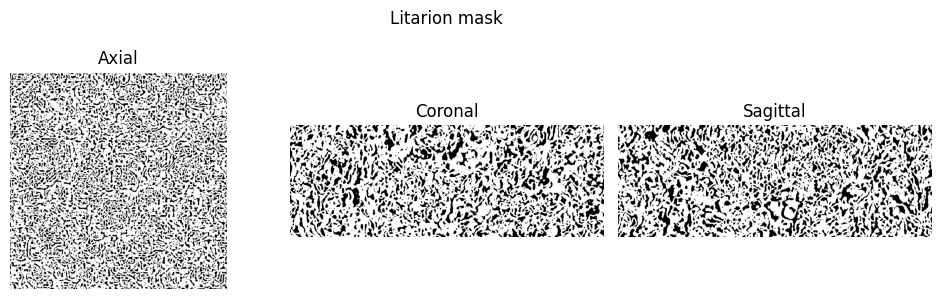

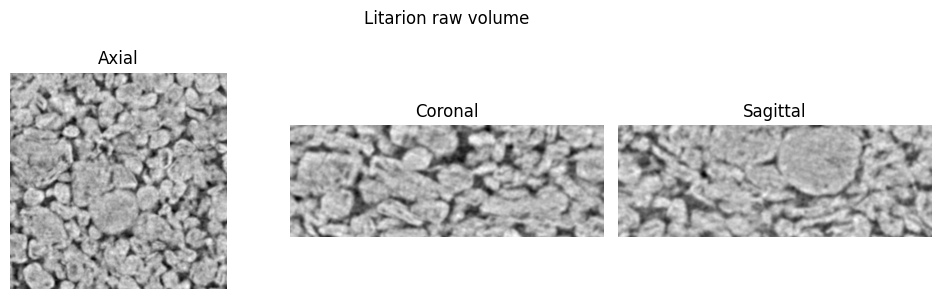

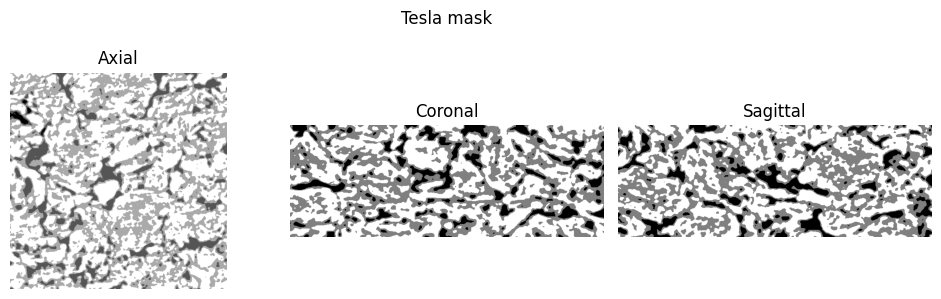

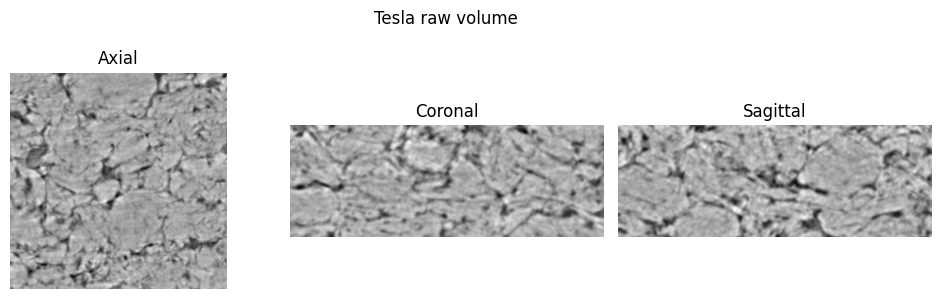

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
vol = tiff.imread("../data/Litarion.tif").astype(np.float32)
print("shape:", vol.shape, "dtype:", vol.dtype)

# show mid-slices
def show3(v: np.ndarray, title=""):
    z, y, x = v.shape
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    axs[0].imshow(v[z//2], cmap="gray"); axs[0].set_title("Axial")
    axs[1].imshow(v[:,y//2,:], cmap="gray"); axs[1].set_title("Coronal")
    axs[2].imshow(v[:,:,x//2], cmap="gray"); axs[2].set_title("Sagittal")
    for a in axs: a.axis("off")
    fig.suptitle(title); plt.tight_layout(); plt.show()
mask_vol = tiff.imread("../data/results/Litarion/Litarion_mask.tif").astype(np.float32)
mask_sony = tiff.imread("../results/Sony_VTC5/Sony_VTC5_mask.tif").astype(np.float32)
mask_litarion = tiff.imread("../results/Litarion/Litarion_mask.tif").astype(np.float32)
mask_tesla = tiff.imread("../results/Tesla/Tesla_mask.tif").astype(np.float32)
raw_tesla = tiff.imread("../data/Tesla.tif").astype(np.float32)
raw_litarion = tiff.imread("../data/Litarion.tif").astype(np.float32)
show3(mask_vol, title="Litarion mask")
show3(raw_litarion, title="Litarion raw volume")
show3(mask_tesla, title="Tesla mask")
show3(raw_tesla, title="Tesla raw volume")

In [4]:
from typing import Tuple
from skimage.restoration import denoise_tv_chambolle
from typing import Optional
import SimpleITK as sitk
import numpy as np


def clip_and_scale(
    v: np.ndarray, pcts: Tuple[float, float] = (0.5, 99.5), eps: float = 1e-6
) -> Tuple[np.ndarray, float, float]:
    """Clip and scale a value to the range [0, 1] based on given percentiles.

    Args:
        v: The input value or array to be clipped and scaled.
        pcts: A tuple containing the lower and upper percentiles for clipping.
        eps: A small epsilon value to prevent division by zero.

    Returns:
        A list containing the clipped and scaled array,
        the lower percentile value, and the upper percentile value.
    """
    p1, p2 = np.percentile(v, pcts)

    if not np.isfinite(p1) or not np.isfinite(p2):
        raise ValueError("Percentiles are NaN/Inf")

    if p2 <= p1:
        scaled = np.zeros_like(v, dtype=np.float32)
        return scaled, float(p1), float(p2)
    else:
        clipped: np.ndarray = np.clip(v, p1, p2)
        scaled_v: np.ndarray = (clipped - p1) / (p2 - p1 + eps)
        scaled = scaled_v.astype(np.float32, copy=False)

    np.clip(scaled, 0.0, 1.0, out=scaled)
    return scaled, float(p1), float(p2)

def denoise_tv(volume: np.ndarray, weight: float=0.05, n_iter_max: int = 200, mask: Optional[np.ndarray] = None):
    v = volume.astype(np.float32, copy=False)
    
    if mask is None:
        out = denoise_tv_chambolle(
            v,
            weight=weight,
            max_num_iter=n_iter_max,
            channel_axis=None,
        ).astype(np.float32, copy=False)
    else:
        den = denoise_tv_chambolle(
            v,
            weight=weight,
            max_num_iter=n_iter_max,
            channel_axis=None
        ).astype(np.float32, copy=False)
        out = v.copy()
        out[mask.astype(bool)] = den[mask.astype(bool)]
    
    np.clip(out, 0.0, 1.0, out=out)
    return out


In [5]:
# NLM
import numpy as np
import cv2 as cv
from skimage.restoration import denoise_nl_means, estimate_sigma

def nlm3d(volume: np.ndarray, patch_size=3, patch_distance=6, k=0.9, fast=True):
    v = volume.astype(np.float32, copy=False)
    sigma = float(estimate_sigma(v, channel_axis=None))
    h = max(1e-6, k*sigma)
    out = denoise_nl_means(
        v,
        h=h,
        patch_size=patch_size,
        patch_distance=patch_distance,
        fast_mode=fast,
        channel_axis=None,
        preserve_range=True
    ).astype(np.float32, copy=False)
    return out, h, sigma


def nlm2d_opencv(volume: np.ndarray, h=0.9, template_window=5, search_window=13):
    z, y, x = volume.shape
    out = np.empty_like(volume, dtype=np.float32)
    for i in range(z):
        img8 = np.clip(volume[i]*255, 0, 255).astype(np.uint8)
        den8 = cv.fastNlMeansDenoising(img8, None,
                                        h=float(h*25),     # OpenCV h is ~0–30 for 8-bit
                                        templateWindowSize=template_window,
                                        searchWindowSize=search_window)
        out[i] = den8.astype(np.float32)/255.0
    return out


Scaled to [0,1] using percentiles: -2.22e-06-1.62e-06
min, max, unique= -3.4975624e-06 2.668628e-06 [-3.4975624e-06 -3.4753218e-06 -3.4709017e-06 ...  2.6369062e-06
  2.6478174e-06  2.6686280e-06]


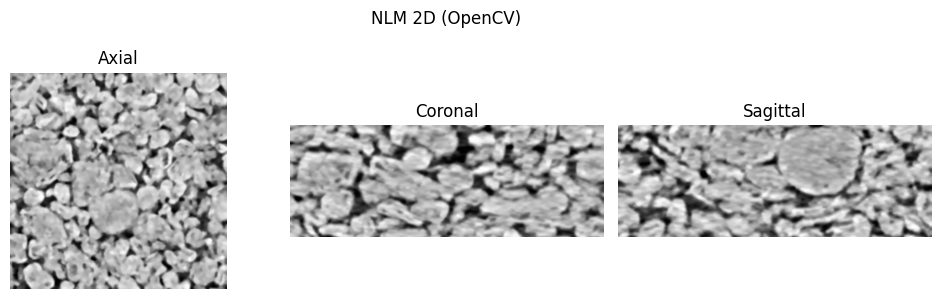

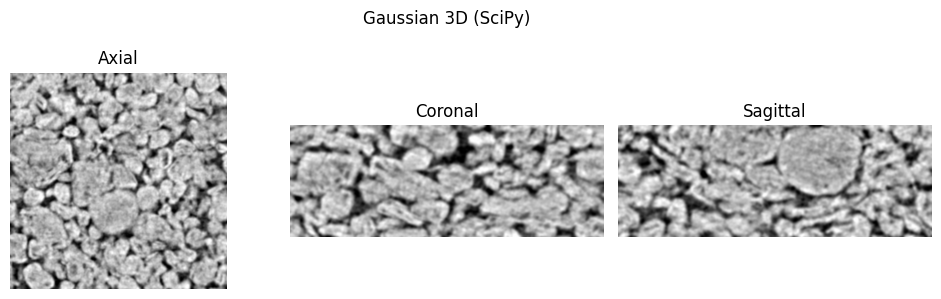

In [6]:
from tifffile import imread
from scipy.ndimage import gaussian_filter

v_raw = imread("../data/Litarion.tif")
v_scaled, p1, p2 = clip_and_scale(v_raw, pcts=(0.5, 99.5))

print(f"Scaled to [0,1] using percentiles: {p1:.2e}-{p2:.2e}")
print("min, max, unique=", np.min(v_raw), np.max(v_raw), np.unique(v_raw))

out_nlm = nlm2d_opencv(v_scaled, h=0.9, template_window=5, search_window=13)

out_gauss = gaussian_filter(v_scaled, sigma=1.0)

show3(out_nlm, "NLM 2D (OpenCV)")
show3(out_gauss, "Gaussian 3D (SciPy)")


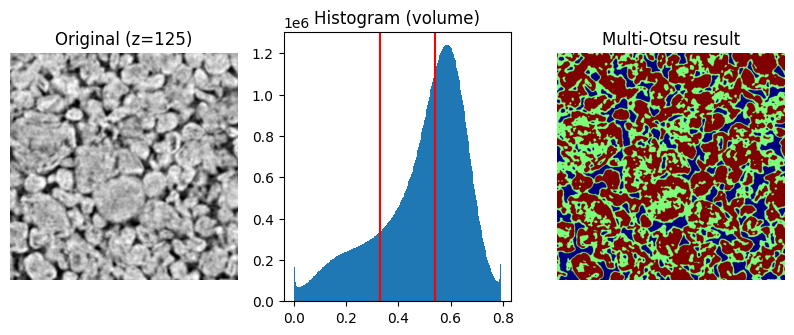

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

image = out_gauss

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

z = image.shape[0] // 2
image2d = image[z, :, :]
regions2d = regions[z, :, :]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image2d, cmap='gray')
ax[0].set_title(f'Original (z={z})')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram (volume)')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions2d, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

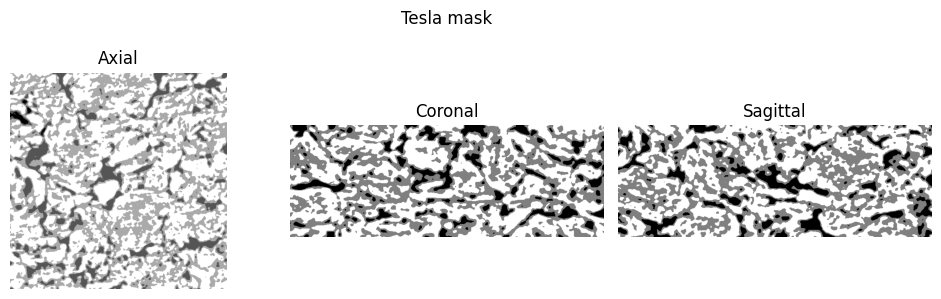

In [8]:
tesla_mask = tiff.imread("../results/Tesla/Tesla_mask.tif").astype(np.float32)

show3(tesla_mask, title="Tesla mask")

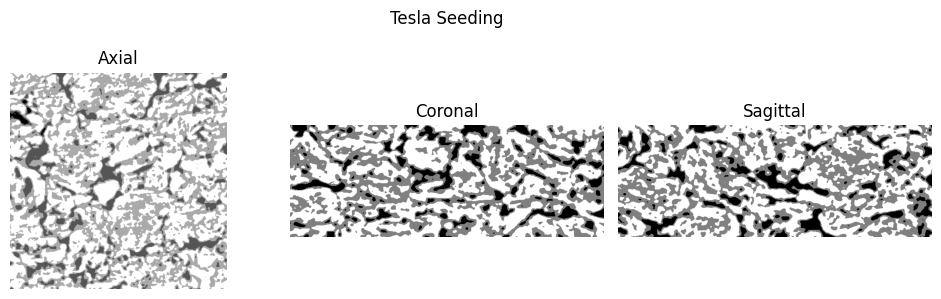

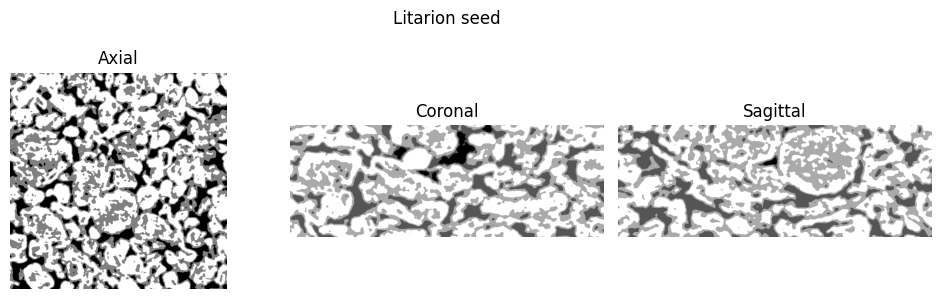

In [11]:
import tifffile as tiff

v_litarion = tiff.imread("../results/Litarion/Litarion_mask.tif")
v_tesla = tiff.imread("../results/Tesla/Tesla_mask.tif")

show3(v_tesla, "Tesla Seeding")
show3(v_litarion, "Litarion seed")